In [5]:
## Example of multiple images reconstruction

In [6]:
# Third party import
import pysap
from pysap.data import get_sample_data
from modopt.math.metrics import ssim
from modopt.opt.proximity import GroupLASSO
import numpy as np
import matplotlib.pyplot as plt

from etomo.operators import Radon2D, WaveletPywt, HOTV
from etomo.reconstructors.forwardradon import RadonReconstructor


In [7]:
# Loading input data
image = get_sample_data('2d-pmri')
n_channels, img_size, _ = image.shape

In [8]:
# Create radon operator and simulate data
theta = np.arange(0., 180., 3.)
radon_op = Radon2D(angles=theta, img_size=img_size, gpu=True,
                   n_channels=n_channels)
data = radon_op.op(image)

In [9]:
# Create operators
TV = HOTV(img_shape=image[0].shape, order=1, n_channels=n_channels)
wavelet = WaveletPywt(wavelet_name='sym8', nb_scale=3, n_channels=n_channels)
linear_op = wavelet

In [10]:
regularizer_op = GroupLASSO(weights=1e-7)
reconstructor = RadonReconstructor(
    data_op=radon_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
)


In [11]:
# Run reconstruction
x_final, cost, *_ = reconstructor.reconstruct(
    data=data,
    optimization_alg='pogm',
    num_iterations=200,
    cost_op_kwargs={'cost_interval': 5}
)


100% (200 of 200) |######################| Elapsed Time: 0:03:29 Time:  0:03:29


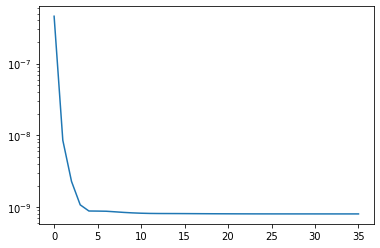

The Reconstruction SSIM is:  0.927435


In [18]:
# Results
plt.plot(cost)
plt.yscale('log')
plt.show()

image_ref = pysap.Image(data=np.sqrt(np.sum(image.data**2, axis=0)))
image_rec = pysap.Image(data=np.sqrt(np.sum(np.abs(x_final)**2, axis=0)))
recon_ssim = ssim(image_rec, image_ref)
print(f'The Reconstruction SSIM is: {recon_ssim: 2f}')
#print('The Reconstruction SSIM is: {}'.format(recon_ssim))
image_rec.show()
